# 프로젝트 루브릭

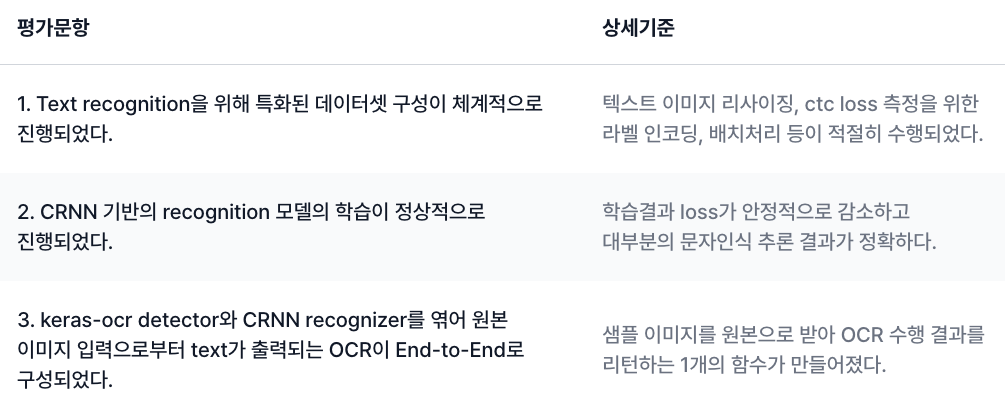

In [21]:
!nvidia-smi

Wed Jul 10 06:31:27 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.256.02   Driver Version: 470.256.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |    508MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# End-to-End OCR

In [73]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

import PIL
from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

import cv2
import keras_ocr

from IPython.display import display

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)
print(TRAIN_DATA_PATH)

2.6.0
1.21.4
8.3.2
4.5.3
0.8.8
/aiffel/aiffel/ocr/data/MJ/MJ_train


In [74]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


이미지 경로를 받아 해당 이미지 내의 문자를 찾아내는 함수를 keras-ocr의 Detector를 이용해서 만들어보세요! inference한 후에는 이를 시각화하도록 합니다. 단어의 영역을 잘라오도록 해주세요.

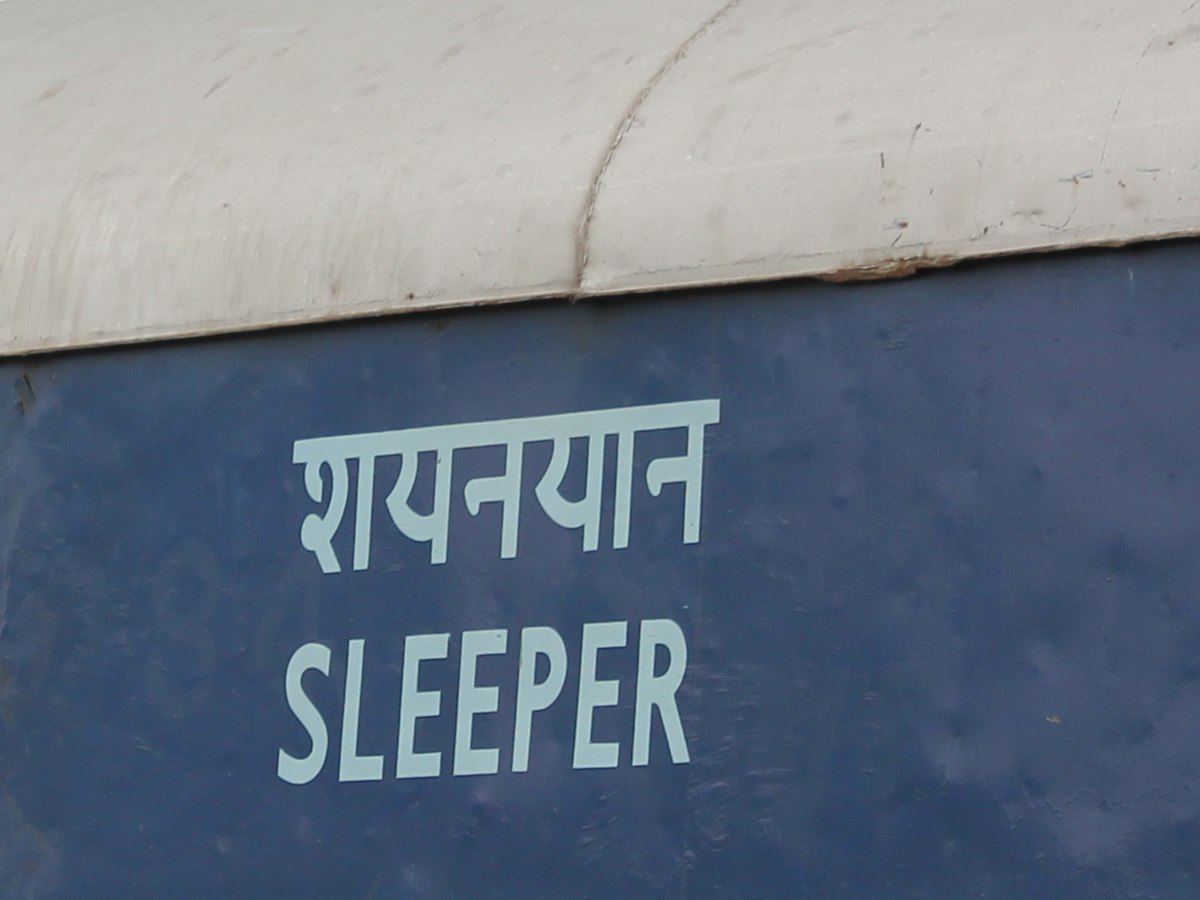

(1, 1200, 900, 3)


In [75]:
img = Image.open(SAMPLE_IMG_PATH)
display(img)
img = np.expand_dims(np.array(img).transpose(1,0,2), axis=0)
print(img.shape) # (bs, w, h, c)

In [76]:
!tree

.
├── OCR_Practice.ipynb
└── OCR_Project.ipynb

0 directories, 2 files


In [150]:
class LabelConverter(object):

    def __init__(self, character):
        self.character = "-" + character # 0은 '-'에 해당 
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label: 
            decoded_label += self.character[encode]
        return decoded_label

In [151]:
from PIL import ImageDraw

def detect_text(img_path):
    
    # TODO
    
    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    img_pil = Image.open(SAMPLE_IMG_PATH)
    img = np.array(img_pil)
    
#     print(img.shape)
    img_exp = np.expand_dims(img, axis=0)
    H, W, C = img.shape
    img_input = img_exp.reshape((1, H, W, C))
    
    # 배치의 첫 번째 결과만 가져옵니다.
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    print('display img shape:{}'.format(img.shape))

    display(Image.fromarray(img_input[0]))
    detector = Detector()
    # 단어 이미지를 얻기 위해 호출
    ocr_result = detector.detect(img_input) 
    # HxWx3 or list of filepaths, return boxes
    
#     print(ocr_result)
    ocr_result = ocr_result[0]
    
    img_draw = ImageDraw.Draw(img_pil, "RGB")
    
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return img_pil, cropped_imgs

In [152]:
!pwd

/aiffel/aiffel/AIFFEL_RESEARCH_STUDY/Quests/Quest11_20240709


display img shape:(900, 1200, 3)


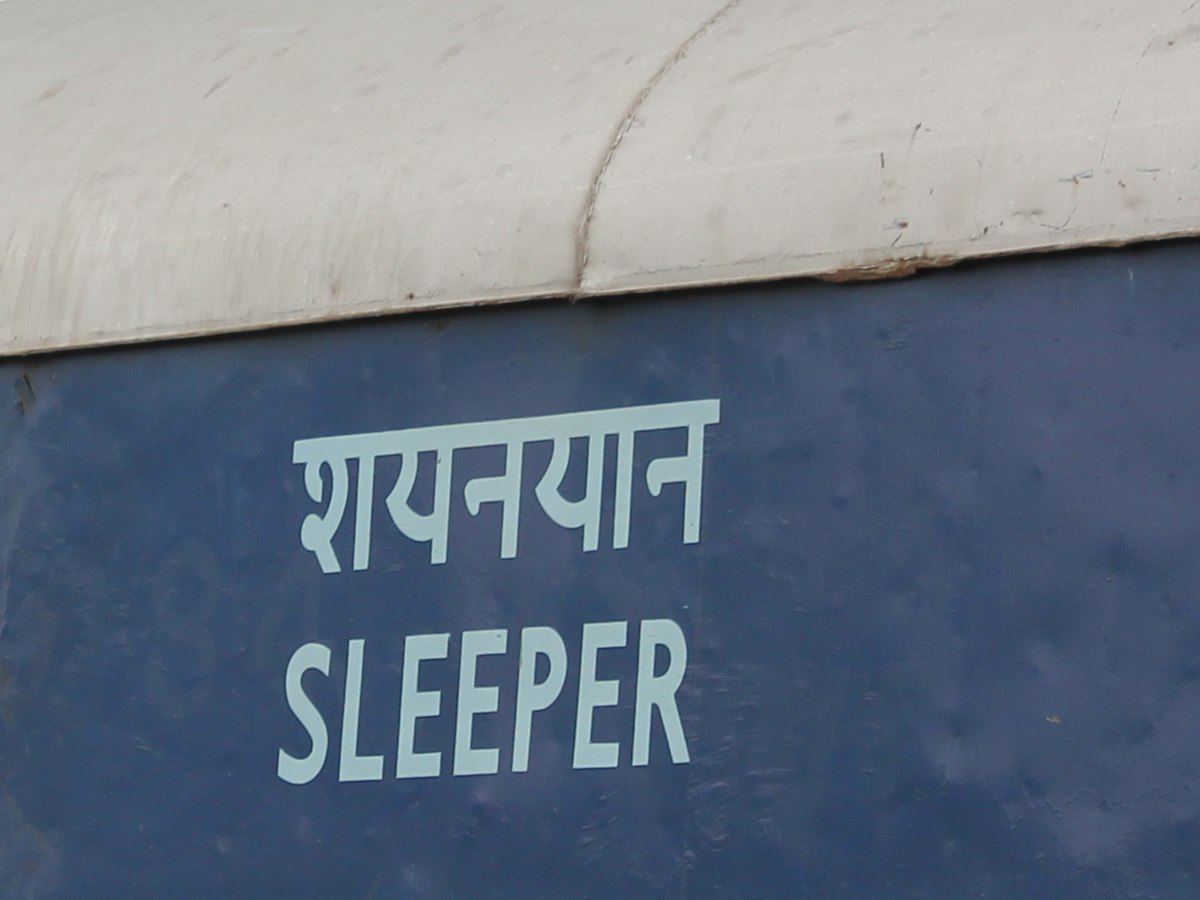

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


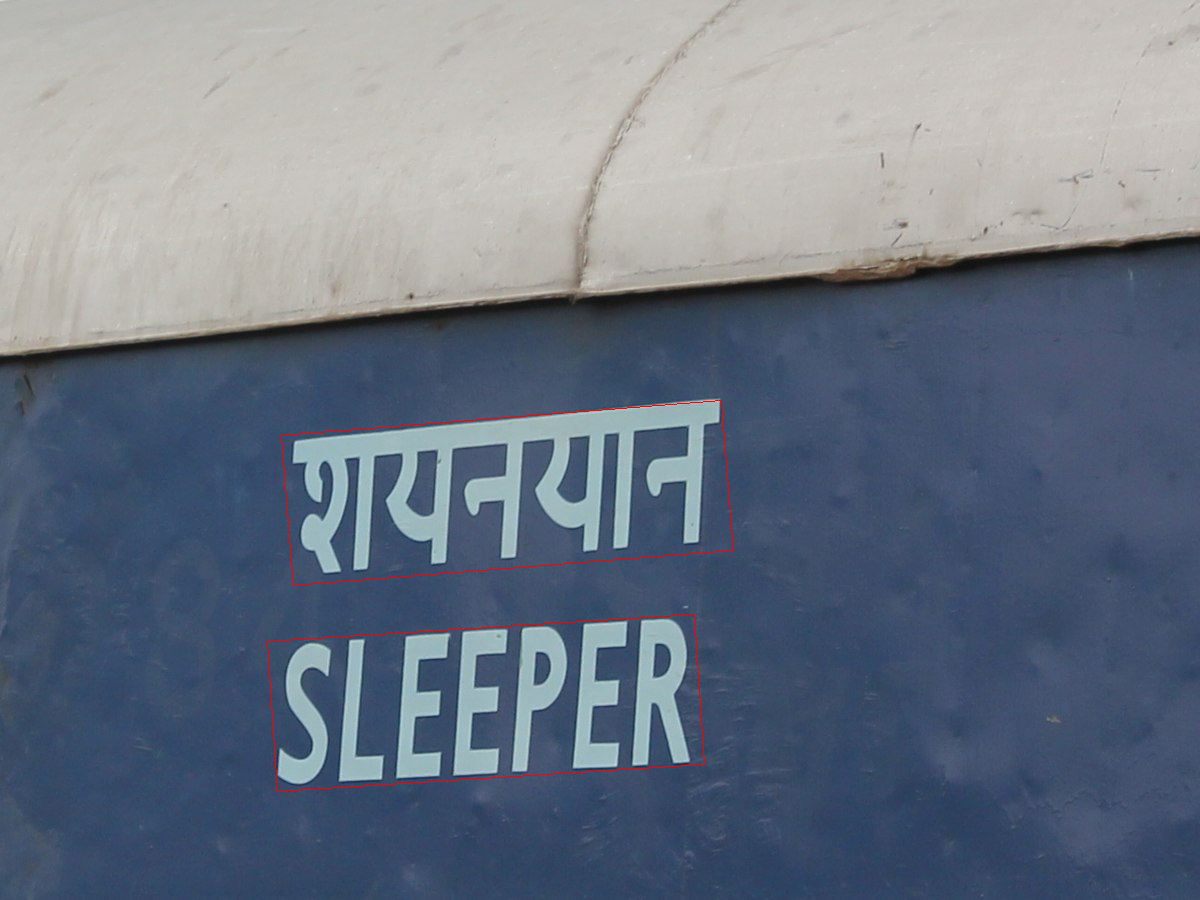

In [153]:
label_converter = LabelConverter(TARGET_CHARACTERS) # 숫자, 영대문자를 포함한 String을 인자로 삽입
img_pil, cropped_img = detect_text(HOME_DIR + '/data')
display(img_pil)

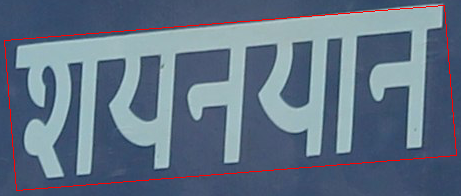

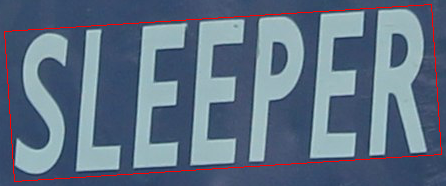

In [154]:
for _img in cropped_img :
    display(_img)

이제 위에서 이미지 내의 단어 이미지를 얻었습니다. 그럼 Recognition model로 인식하는 함수를 직접 작성하고 그 결과를 출력해보세요!

In [161]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

[루브릭 1] 학습 노드의 예시코드들을 참조하여, 리사이징, CTC loss encoding(LableConverter) 및 배치처리(MJDatasetSequence)를 진행하여 학습했습니다.
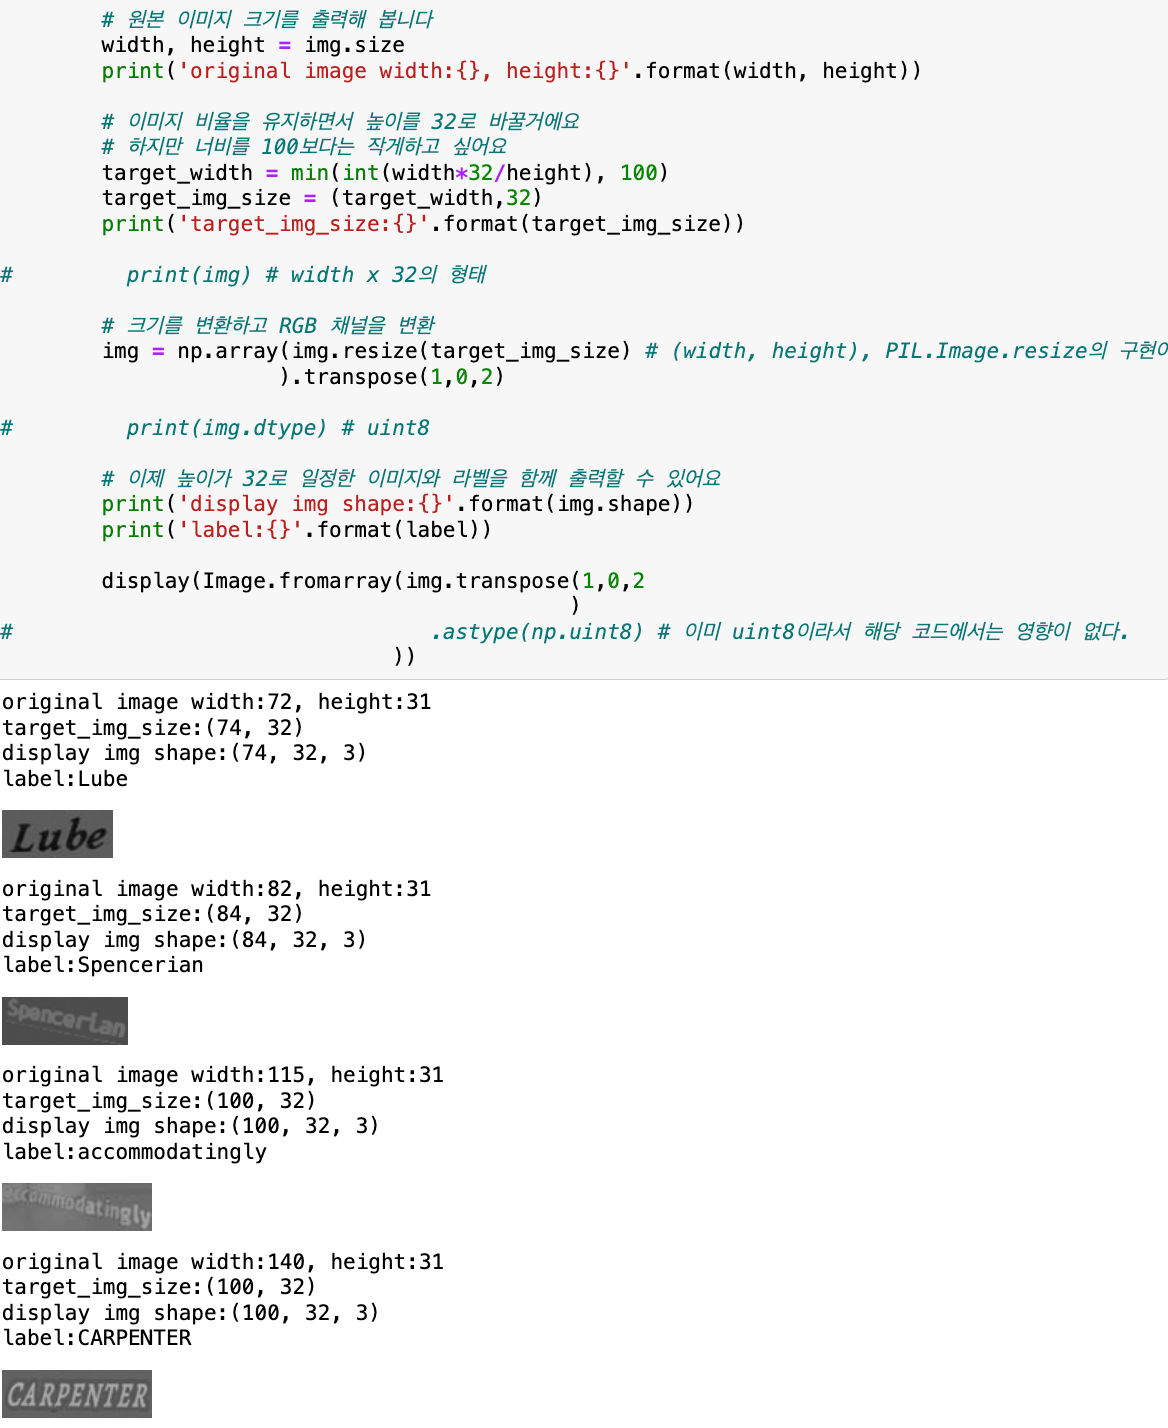
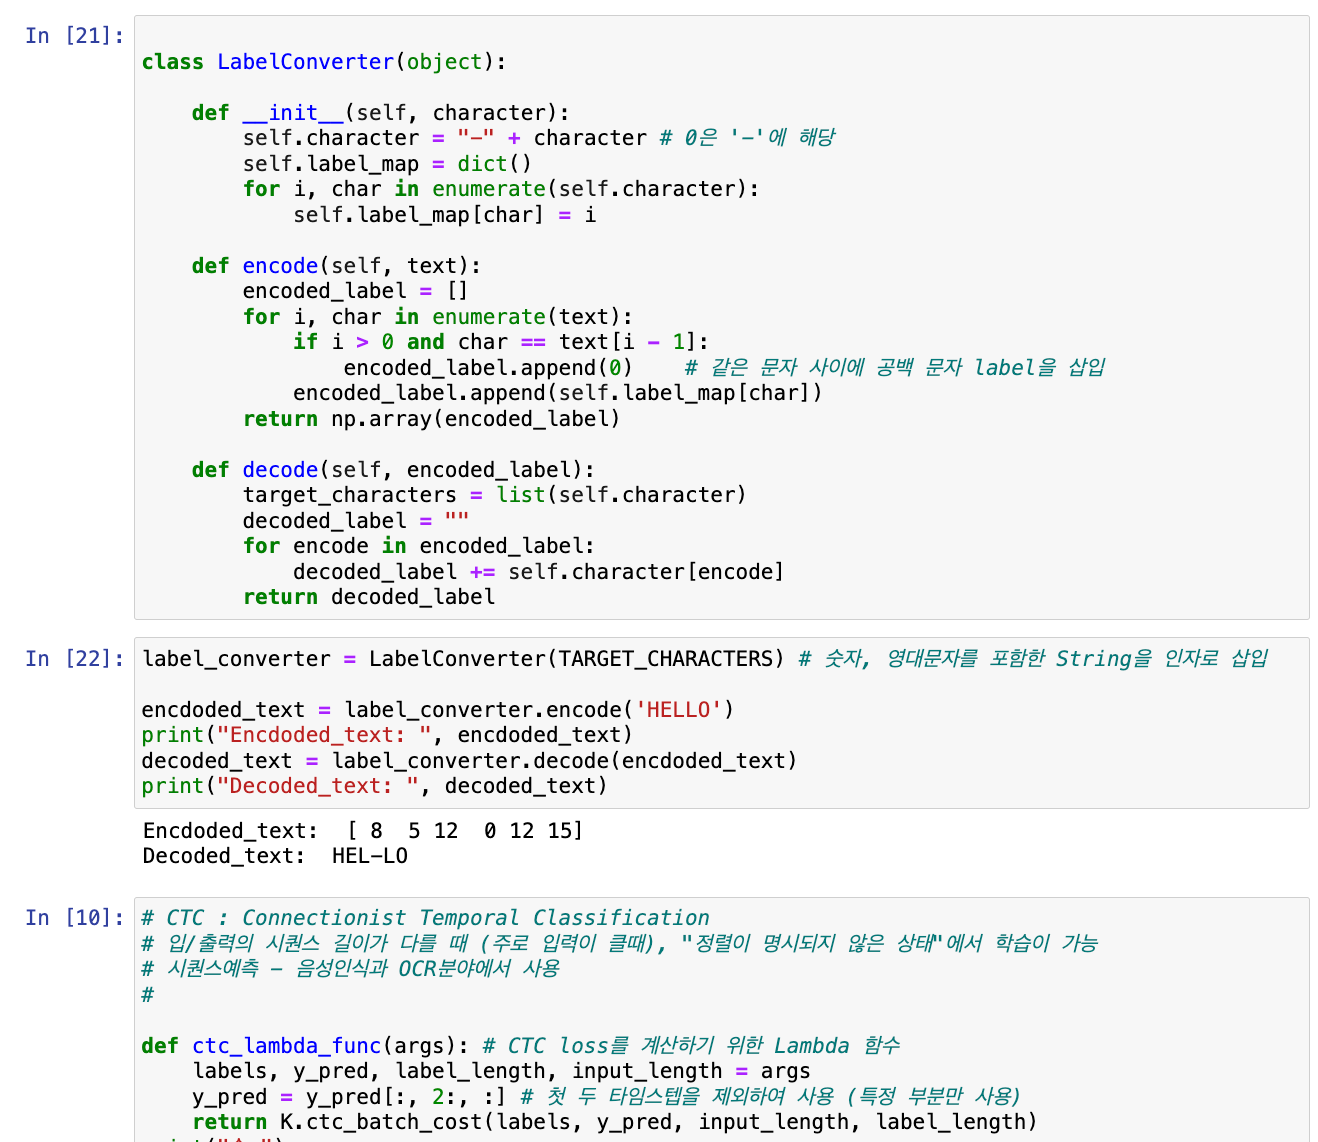


In [162]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [163]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)

    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)

    # RNN 부분
    sequnce = layers.Reshape(target_shape=(24, 512))(feature) # feature to sequence
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    # 분류기의 최종 예측
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

- [루브릭 2] : recognition 모델 학습 시 loss의 감소 확인
    동일 폴더 내, OCR_Practice 참조
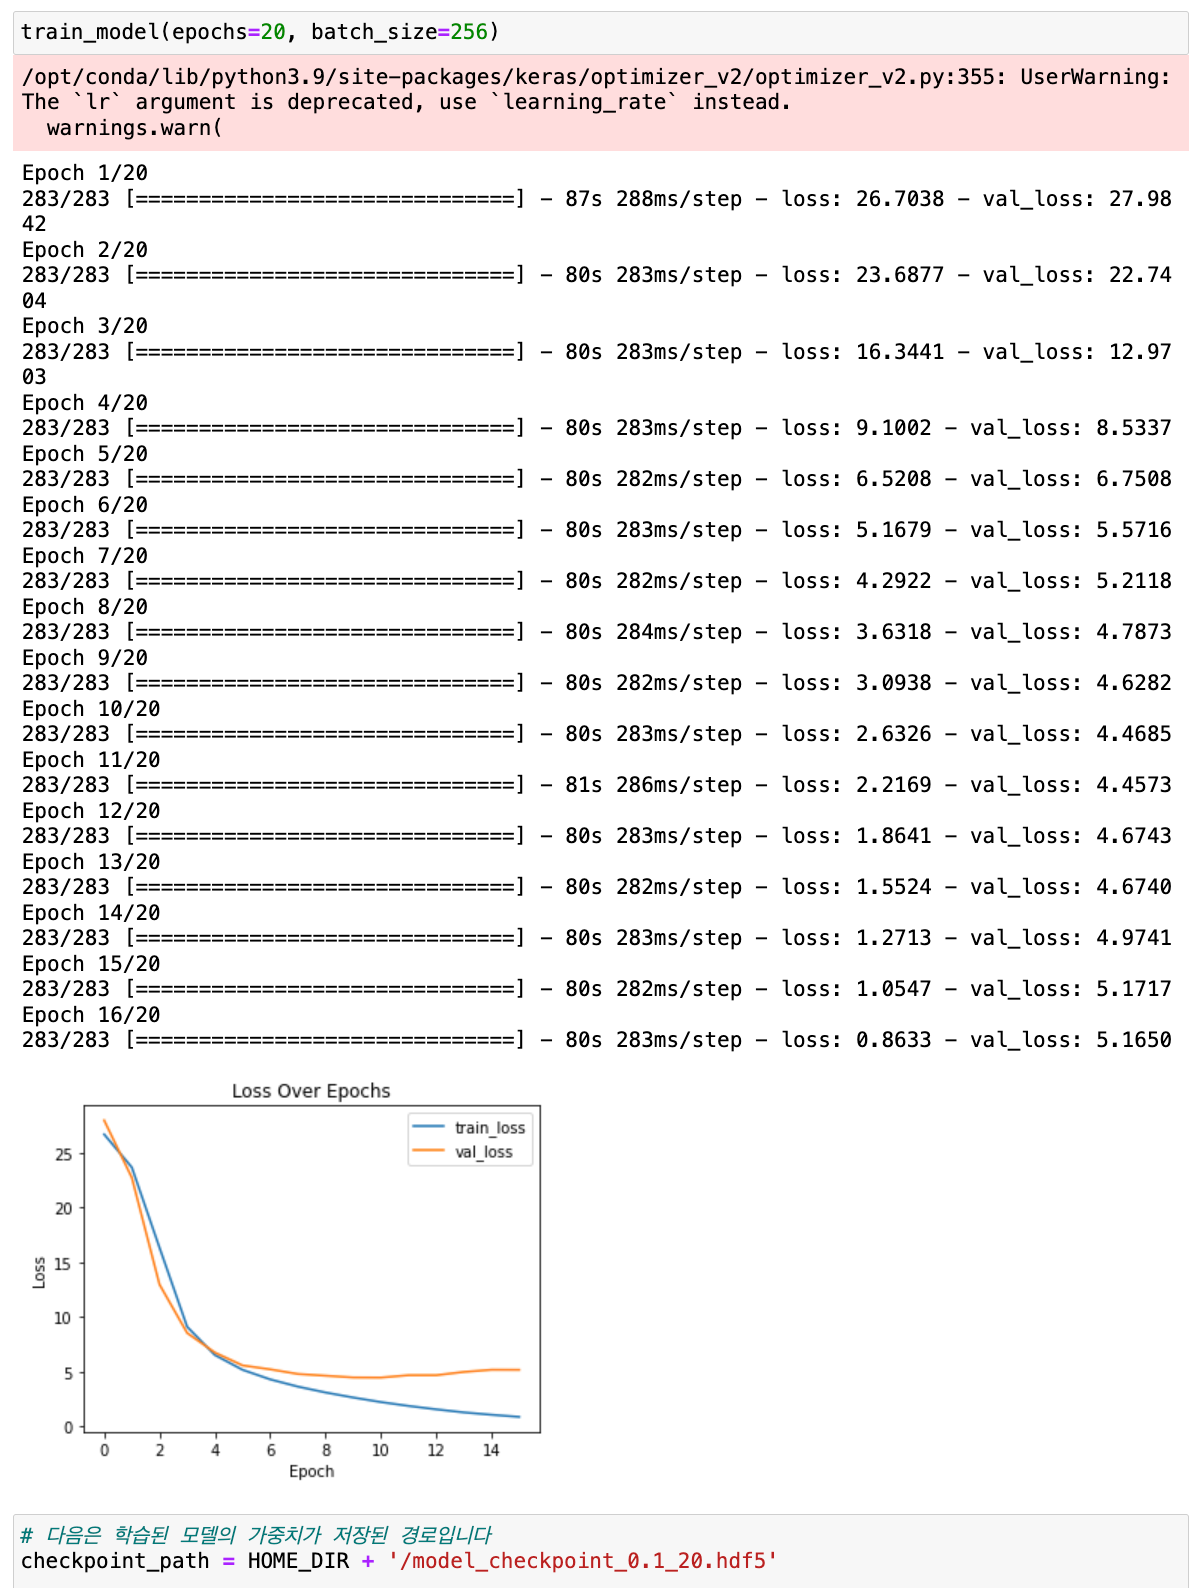

> Loss가 cross되는 포인트를 콜백의 save_best_only를 통해서 저장

In [164]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/model_checkpoint_0.1_20.hdf5' 
# 학습 잘 된 Recognition 모델 사용

In [165]:
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

In [186]:
def recognize_img(pil_img, input_img_size=(100,32)):
    
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!
    # 데이터셋과 모델을 불러옵니다
    
    model = build_crnn_model()
    model.load_weights(checkpoint_path)

    # crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
    # 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
    # inference 전용 모델이에요 

    # 입, 출력 레이어를 뽑아서 Model을 다시 정의
    input_data = model.get_layer('input_image').output
    y_pred = model.get_layer('output').output
    model_pred = Model(inputs=input_data, outputs=y_pred)
    
#     width, height = pil_img.size
#     target_width = min(int(width*32/height), 100)
#     target_img_size = (target_width,32)        
    img = np.expand_dims(np.array(pil_img.resize(input_img_size) # (width, height), PIL.Image.resize의 구현이슈
                      ).transpose(1,0,2), axis=0)    
    
#     input_images = np.zeros([1, 100, 32, 3])
#     input_images[0, :width, :, :] = img
    
#     img_pred = model_pred.predict(input_images)
    img_pred = model_pred.predict(img)
    
    result = decode_predict_ctc(img_pred, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))
    

[루브릭 3] 1개의 함수로 만들었다.

In [187]:
def end_to_end_ocr(img_path):
    img_pil, cropped_img = detect_text(img_path)
    
    for _img in cropped_img:
        print(type(_img))
        recognize_img(_img)

display img shape:(900, 1200, 3)


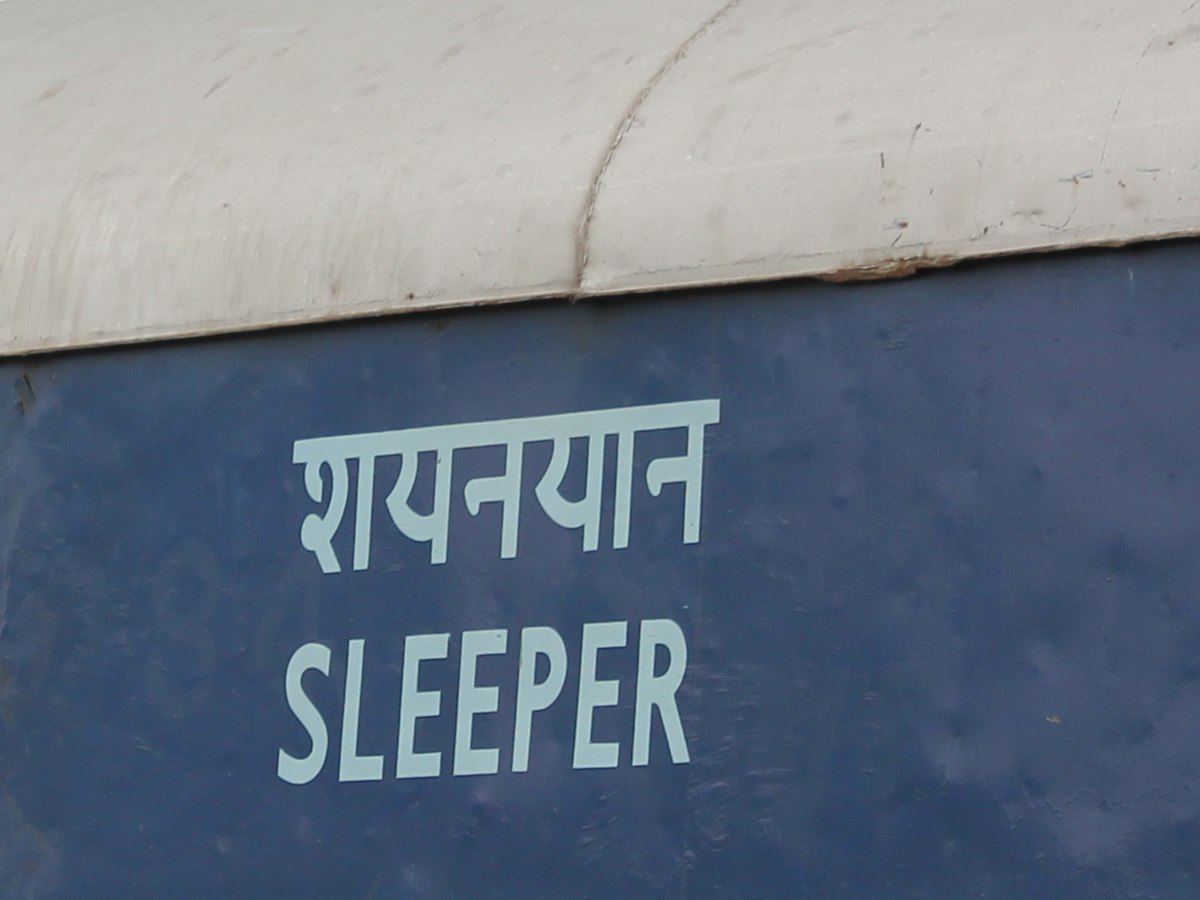

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
<class 'PIL.Image.Image'>
Result: 	 VRERIST9999999999999999


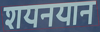

<class 'PIL.Image.Image'>
Result: 	 SLEEPER9999999999999999


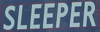

In [188]:
end_to_end_ocr(SAMPLE_IMG_PATH)

- 영문은 맞게 나오는 것을 확인하였다.

# 회고

- 일정에 허덕여 하이퍼 파라미터 최적화를 많이 못 해본 것이 아쉬웠다. Wandb로 엮어보고싶다.
- Vision task들을 하나하나 배워나가는 것은 어렵기도 하지만 흥미롭다.
- 시간이 조금 된다면 CTC 알고리즘에 대해 좀 더 탐구해보는 것도 좋을 것 같고, Accuracy metric에 사용할 수 있도록 Custom callback을 만드는 것도 괜찮을 것 같음.
- 기본기에 충실하자.